In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader
import pytorch_lightning as pl

from src.autoencoder import AutoEncoder
from src.utils import *
from src.rtd import RTDLoss, Rips, RTD_differentiable
from src.top_ae import TopologicallyRegularizedAutoencoder

import umap

from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from collections import defaultdict
from itertools import chain

from tqdm.notebook import tqdm

In [3]:
np.random.seed(42)

# Planned experiments:

1. Compare classification accuracies of KNN for various 'k'-s for labeled datasets for UMAP, t-SNE, Autoencoders, topological autoencoders on cross-validation
2. Compare inference time, training time
3. Run qualitive comparison (vizualization) 
4. Inspect different autoencoder architechtures (?)
5. Explore different distances in the original space (?)


Baselines to be compared to:

 - **PCA**
 - **UMAP**
 - **TopAE**
 - **Basic autoencoders**
 
 Values of assessment:
 
 Experiments:
  - **Initial**: Compare autoencoders and baselines it on all datasets (accuracy of prediction for labeled, time of training, vizualization)
  - **Hyperparameters**: Compare different $\lambda$'s and different regularity of loss computation 
  - **Only topological loss**: train encoders with only topological loss, different dimensions and symm/non-symm ways
  - **Architechture**: Compare different architechtures of autoencoders
  - **Distances**: compare different distance functions (euclidean / manhattan / _geodesics_) in terms of interclass/outerclass distance (mean, std, frac) and in terms of quality of predictions of AE

# Experiment 0

Models to compare:
 - Basic autoencoder baseline
 - PCA baseline
 - RTD + autoencoder (2 different types)
 - UMAP
 
Modes to compare:
 - Accuracy of KNN classifier (for different 'k'-s)
 - Train / inference time
 - Visual qualitive analysis
 
Datasets:
 - MNIST
 - F-MNIST
 - Pendigits
 - COIL-20
 - COIL-100
 - Shuttle
 - Flow

In [4]:
config = {
    "dataset_name":"Spheres",
    "version":"",
    "model_name":"default",
    "max_epochs":40,
    "gpus":[0],
    "n_neighbors":[5, 20, 100, 400],
    "rtd_every_n_batches":1,
    "rtd_start_epoch":15,
    "rtd_l":1.0, # rtd loss 
    "n_runs":1, # number of runs for each model
    "card":50, # number of points on the persistence diagram
    "n_threads":50, # number of threads for parallel ripser computation of pers homology
    "latent_dim":2, # latent dimension (2 for vizualization purposes)
    "input_dim":28*28,
    "n_hidden_layers":2,
    "hidden_dim":32,
    "batch_size":40,
    "is_sym":True
}

In [5]:
def get_model(input_dim, latent_dim=2, n_hidden_layers=2, hidden_dim=32, m_type='encoder'):
    layers = list(
        chain.from_iterable(
            [
                (nn.Linear(hidden_dim, hidden_dim), nn.ReLU()) for _ in range(n_hidden_layers)
            ]
        )
    )
    if m_type == 'encoder':
        layers = [nn.Linear(input_dim, hidden_dim), nn.ReLU()] + layers + [nn.Linear(hidden_dim, latent_dim)]
    elif m_type == 'decoder':
        layers = [nn.Linear(latent_dim, hidden_dim), nn.ReLU()] + layers + [nn.Linear(hidden_dim, input_dim)]
    return nn.Sequential(*layers)

def get_list_of_models(**config):
    # define a list of models
    models = {
        'Basic AutoEncoder':AutoEncoder(
           encoder = get_model(
                config["input_dim"], 
                config["latent_dim"], 
                config["n_hidden_layers"], 
                config["hidden_dim"], 
                m_type='encoder'
            ),
            decoder = get_model(
                config["input_dim"], 
                config["latent_dim"], 
                config["n_hidden_layers"], 
                config["hidden_dim"], 
                m_type='decoder'
            ),
            MSELoss = nn.MSELoss(),
            **config
        ),
        'Topological AutoEncoder':TopologicallyRegularizedAutoencoder(
            encoder = get_model(
                config["input_dim"], 
                config["latent_dim"], 
                config["n_hidden_layers"], 
                config["hidden_dim"], 
                m_type='encoder'
            ),
            decoder = get_model(
                config["input_dim"], 
                config["latent_dim"], 
                config["n_hidden_layers"], 
                config["hidden_dim"], 
                m_type='decoder'
            ),
            MSELoss = nn.MSELoss(),
            **config
        ),
        "UMAP":umap.UMAP(n_components=2),
        "PCA":PCA(n_components=2),
        'RTD AutoEncoder H0':AutoEncoder(
            encoder = get_model(
                config["input_dim"], 
                config["latent_dim"], 
                config["n_hidden_layers"], 
                config["hidden_dim"], 
                m_type='encoder'
            ),
            decoder = get_model(
                config["input_dim"], 
                config["latent_dim"], 
                config["n_hidden_layers"], 
                config["hidden_dim"], 
                m_type='decoder'
            ),
            RTDLoss = RTDLoss(dim=1, **config), # only H0
            MSELoss = nn.MSELoss(),
            **config
        ),
        'RTD AutoEncoder H1':AutoEncoder(
            encoder = get_model(
                config["input_dim"], 
                config["latent_dim"], 
                config["n_hidden_layers"], 
                config["hidden_dim"], 
                m_type='encoder'
            ),
            decoder = get_model(
                config["input_dim"], 
                config["latent_dim"], 
                config["n_hidden_layers"], 
                config["hidden_dim"], 
                m_type='decoder'
            ),
            RTDLoss = RTDLoss(dim=2, **config), # only H1
            MSELoss = nn.MSELoss(),
            **config
        )
    }
    return models

In [6]:
# models = get_list_of_models(**config)

### Calculate

In [7]:
def collate_with_matrix(samples):
    indicies, data, labels = zip(*samples)
    data, labels = torch.tensor(np.asarray(data)), torch.tensor(np.asarray(labels))
    return data, torch.cdist(data, data, p=2) / data.shape[1], labels

In [8]:
# load data
dataset_name = config['dataset_name']
train_data = np.load(f'data/{dataset_name}/prepared/train_data.npy').astype(np.float32)
train_labels = np.load(f'data/{dataset_name}/prepared/train_labels.npy')

try:
    test_data = np.load(f'data/{dataset_name}/prepared/test_data.npy').astype(np.float32)
    test_labels = np.load(f'data/{dataset_name}/prepared/test_labels.npy')
except FileNotFoundError:
    train_data, test_data, train_labels, test_labels = train_test_split(
        train_data, train_labels, test_size=0.1, random_state=42
    )

# scaler = MinMaxScaler()
scaler = None
train = FromNumpyDataset(train_data, train_labels, scaler = scaler)
test = FromNumpyDataset(test_data, test_labels, scaler = train.scaler)

train_loader = DataLoader(
    train, 
    batch_size=config["batch_size"], 
    num_workers=2, 
    collate_fn=collate_with_matrix, 
    shuffle=True
)
val_loader = DataLoader(
    test,
    batch_size=config["batch_size"],
    num_workers=2,
    collate_fn=collate_with_matrix,
)

In [9]:
def train_autoencoder(model, train_loader, val_loader=None, model_name='default', 
                      dataset_name='MNIST', gpus=[3], max_epochs=100, run=0, version=""):
    version = f"{dataset_name}_{model_name}_{version}_{run}"
    logger = pl.loggers.TensorBoardLogger(save_dir=os.getcwd(), name='lightning_logs', version=version)
    trainer = pl.Trainer(
        logger=logger, 
        gpus=gpus, 
        max_epochs=max_epochs, 
        log_every_n_steps=50, 
        num_sanity_val_steps=0
    )
    trainer.fit(model, train_loader, val_loader)
    return model

def train_models(train_loader, val_loader, dataset_name="", max_epochs=1, gpus=[], n_neighbors=[1], n_runs=1, version='', **kwargs):
    training_time = defaultdict(list)
    accuracies = defaultdict(list)
    figures = {} # figures for each model run
    for i in range(n_runs):
        models = get_list_of_models(**kwargs)
        for model_name in tqdm(models, desc=f"Training models, run: {i+1} out of {n_runs}"):
            start_time = time.time()
            if 'AutoEncoder' in model_name: # train an autoencoder
                start_time = time.time()
                models[model_name] = train_autoencoder(
                    models[model_name], 
                    train_loader, 
                    val_loader, 
                    model_name, 
                    dataset_name,
                    gpus,
                    max_epochs,
                    i,
                    version
                )
                val_latent, val_labels = get_latent_representations(models[model_name], val_loader)
                train_latent, train_labels = get_latent_representations(models[model_name], train_loader)
            else: # umap / pca / t-sne (sklearn interface)
                train_latent = models[model_name].fit_transform(train.data.numpy())
                val_latent =  models[model_name].transform(test.data.numpy())
            end_time = time.time()
            training_time[model_name].append(end_time-start_time)
            fig, _ = plot_latent(train_latent, train_labels, val_latent, val_labels, model_name, dataset_name)
            figures[model_name + f"_{i}"] = fig
            for k in n_neighbors:
                classifier = KNeighborsClassifier(n_neighbors=k)
                classifier.fit(train_latent, train_labels)
                pred_labels = classifier.predict(val_latent)
                accuracies[model_name + f"_k{k}"].append(accuracy_score(val_labels, pred_labels))
            json.dump(accuracies, open(f'results/{dataset_name}/{dataset_name}_{version}_acc.json', 'w'))
    # save figures
    for model_name in figures:
        figures[model_name].savefig(f'results/{dataset_name}/{dataset_name}_{model_name}_{version}.png')
#     acc, times = {}
#     for model_name_k in accuracies:
#         acc[model_name_k] = {
#             'mean':np.mean(accuracies[model_name_k]), 
#             'std':np.std(accuracies[model_name_k])
#         }
#     for model_name in training_time:
#         training_time[model_name] = {
#             'mean':np.mean(training_time[model_name]), 
#             'std':np.std(training_time[model_name])
#         }
    # save training times
    json.dump(training_time, open(f'results/{dataset_name}/{dataset_name}_{version}_time.json', 'w'))
    # save accuracies
    json.dump(accuracies, open(f'results/{dataset_name}/{dataset_name}_{version}_acc.json', 'w'))
    return accuracies, figures, training_time

Using python to compute signatures


Training models, run: 1 out of 3:   0%|          | 0/1 [00:00<?, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name     | Type                         | Params
----------------------------------------------------------
0 | encoder  | Sequential                   | 27.3 K
1 | decoder  | Sequential                   | 28.1 K
2 | MSELoss  | MSELoss                      | 0     
3 | topo_sig | TopologicalSignatureDistance | 0     
----------------------------------------------------------
55.4 K    Trainable params
0         Non-trainable params
55.4 K    Total params
0.222     Total estimated model params size (MB)
/workspace/topological_autoencoders/.env/lib/python3.6/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:623: UserWarning: Checkpoint directory /workspace/topological_autoencoders/lightning_logs/MNIST_Topological AutoEncoder_topae_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} e

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Using python to compute signatures


Training models, run: 2 out of 3:   0%|          | 0/1 [00:00<?, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name     | Type                         | Params
----------------------------------------------------------
0 | encoder  | Sequential                   | 27.3 K
1 | decoder  | Sequential                   | 28.1 K
2 | MSELoss  | MSELoss                      | 0     
3 | topo_sig | TopologicalSignatureDistance | 0     
----------------------------------------------------------
55.4 K    Trainable params
0         Non-trainable params
55.4 K    Total params
0.222     Total estimated model params size (MB)
/workspace/topological_autoencoders/.env/lib/python3.6/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:623: UserWarning: Checkpoint directory /workspace/topological_autoencoders/lightning_logs/MNIST_Topological AutoEncoder_topae_1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} e

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Using python to compute signatures


Training models, run: 3 out of 3:   0%|          | 0/1 [00:00<?, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name     | Type                         | Params
----------------------------------------------------------
0 | encoder  | Sequential                   | 27.3 K
1 | decoder  | Sequential                   | 28.1 K
2 | MSELoss  | MSELoss                      | 0     
3 | topo_sig | TopologicalSignatureDistance | 0     
----------------------------------------------------------
55.4 K    Trainable params
0         Non-trainable params
55.4 K    Total params
0.222     Total estimated model params size (MB)
/workspace/topological_autoencoders/.env/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:112: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 88 which is the number of cpus on this machine) in

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

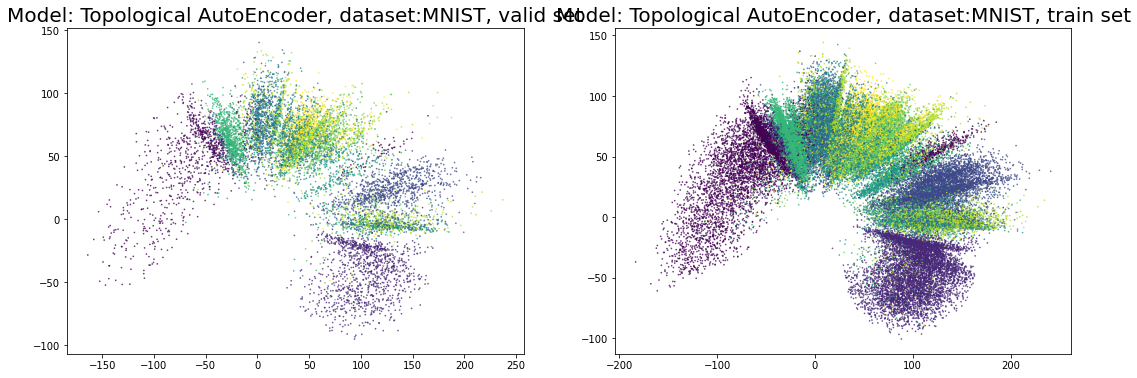

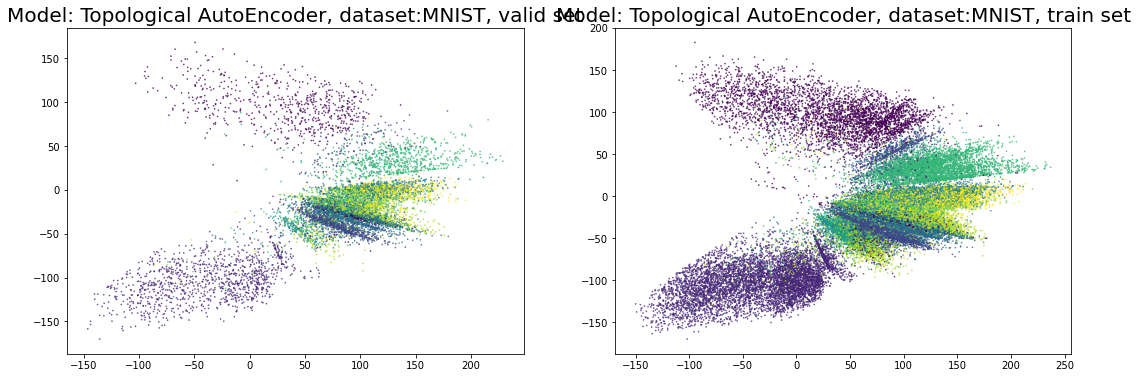

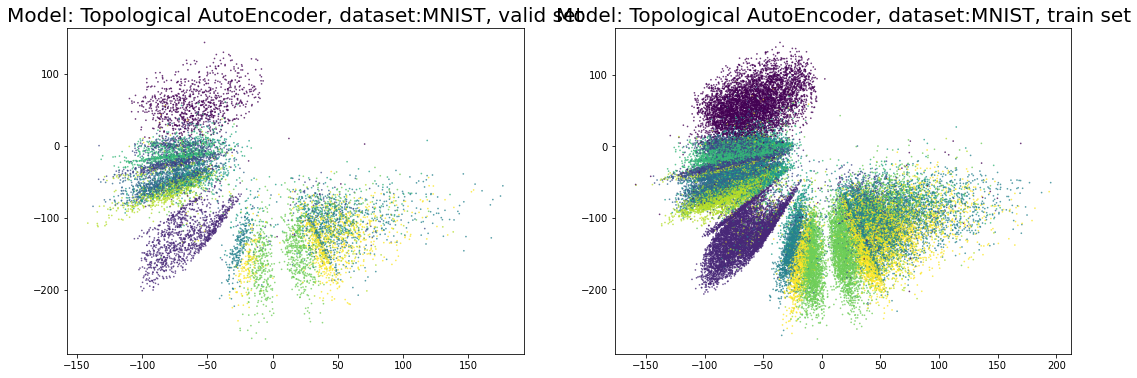

In [10]:
acc, figures, training_time = train_models(train_loader, val_loader, **config)

In [11]:
for model_name in training_time:
    print(f"Model: {model_name}, training time: {np.mean(training_time[model_name]) // 60:.0f}m {np.mean(training_time[model_name]) % 60:.1f}s")

Model: Topological AutoEncoder, training time: 37m 54.5s


In [12]:
for model_name_k in acc:
    print(model_name_k)
    print(f"{np.mean(acc[model_name_k]):.3f} {np.std(acc[model_name_k]):.3f}")

Topological AutoEncoder_k5
0.589 0.022
Topological AutoEncoder_k20
0.621 0.023
Topological AutoEncoder_k100
0.629 0.019
Topological AutoEncoder_k400
0.628 0.016
